In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import random
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
data = pd.read_csv('../data/articles_with_topics_assigned.csv')
data.head()

,ID,Content,Topic
0,0,congressional republican new fear come health ...,Legal and Judicial Systems
1,1,bullet shell get counted blood dry votive cand...,Court cases and Crime
2,2,walt disney bambi opened critic praised spare ...,Entertainment and Sports
3,3,death may great equalizer isnt necessarily eve...,Entertainment and Sports
4,4,north korea leader kim said sunday country mak...,International Affairs and Military


In [3]:
topics = data["Topic"]
topics.head()

0            Legal and Judicial Systems
1                 Court cases and Crime
2              Entertainment and Sports
3              Entertainment and Sports
4    International Affairs and Military
Name: Topic, dtype: object

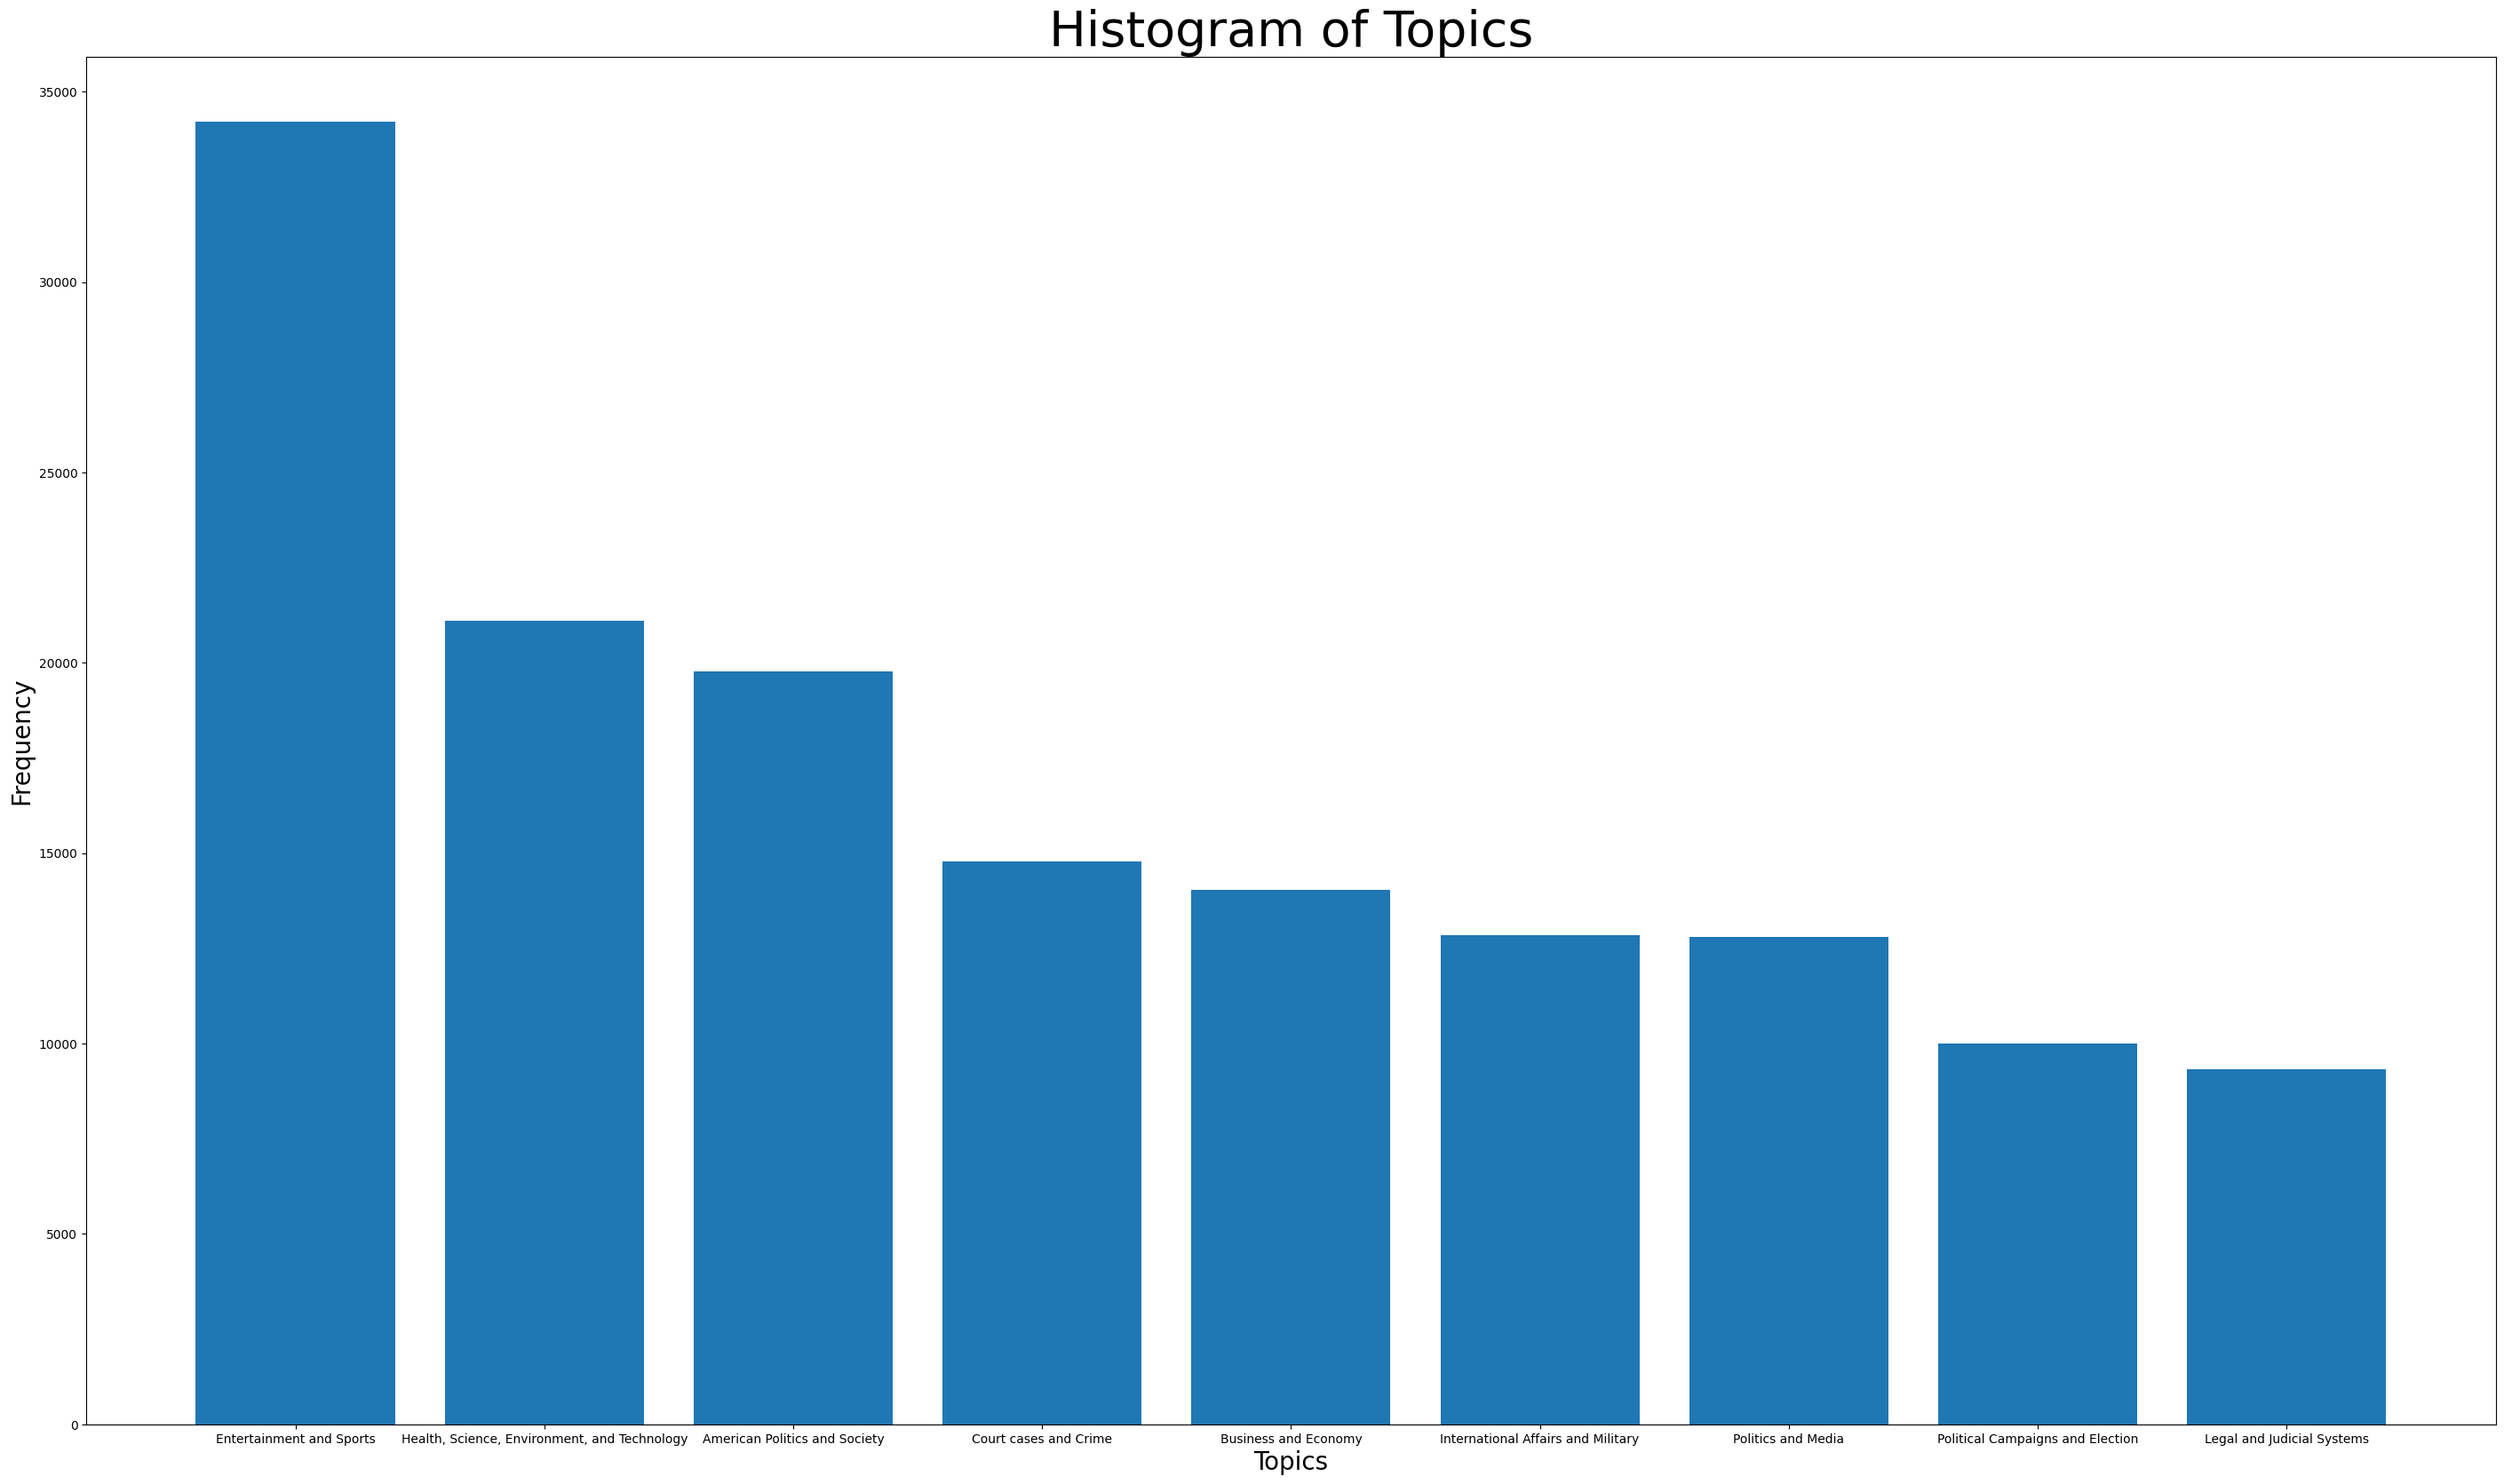

In [4]:
#Histogram of the Dataset

topic_count = topics.value_counts()
plt.figure(figsize=(35, 20))

plt.bar(topic_count.index, topic_count)

plt.xlabel('Topics', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Histogram of Topics', fontsize = 40)
plt.show()

In [5]:
contents = data["Content"]
contents.head()

0    congressional republican new fear come health ...
1    bullet shell get counted blood dry votive cand...
2    walt disney bambi opened critic praised spare ...
3    death may great equalizer isnt necessarily eve...
4    north korea leader kim said sunday country mak...
Name: Content, dtype: object

In [6]:
from collections import defaultdict
import json

In [7]:
glove6B100d = defaultdict(int)
all_possible_words_in_file = []
respective_vector = []
file_path = "glove.6B.100d.txt"

with open(file_path, 'r') as file:
  for line in file:
    items = line.split()
    word = items[0]
    all_possible_words_in_file.append(word)
    numbers = [float(num) for num in items[1:]]
    respective_vector.append(numbers)

In [8]:
word_vectors = []
parsed_articles = [line_of_csv.split() for line_of_csv in contents if len(line_of_csv.split()) > 100]

In [9]:
print(len(parsed_articles))


137716


In [11]:
lengths = [len(sublist) for sublist in parsed_articles]

In [12]:
print(max(lengths))
print(min(lengths))
print(round(np.mean(lengths)))

24974
101
440


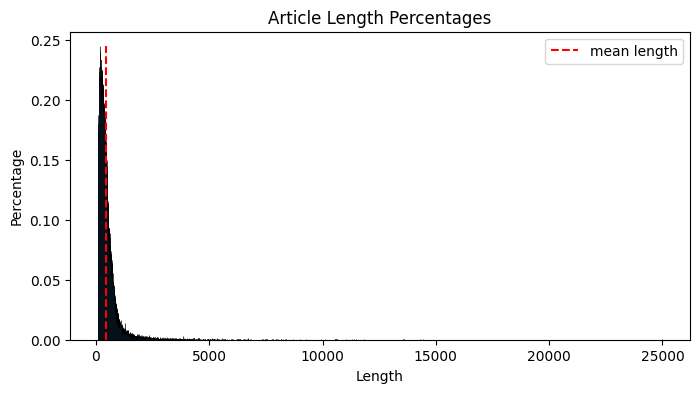


The average sentence length is 440.


In [16]:
from collections import Counter

averageSentenceLength = round(np.mean(lengths))

sentenceCount = Counter(lengths)
sentenceLengthPercentages = {length: (count / len(parsed_articles) * 100) for length, count in sentenceCount.items()}
sortSentenceLength = sorted(sentenceLengthPercentages.items())

sentenceLen = [x[0] for x in sortSentenceLength]
percentSentence = [x[1] for x in sortSentenceLength]


plt.figure(figsize=(8, 4))
plt.bar(sentenceLen, percentSentence, edgecolor='black', linewidth=0.5,width = 1)


plt.xlabel('Length')
plt.ylabel('Percentage')
plt.title('Article Length Percentages')

plt.plot([averageSentenceLength,averageSentenceLength], [0, max(percentSentence)], color = "red", linestyle = "--", label = "mean length")
plt.legend()

plt.show()

print()
print(f"The average sentence length is {round(averageSentenceLength,4)}.")

In [17]:
truncated_article_lst = []
limit = round(np.mean(lengths))
for sublist in parsed_articles:
        # Join the sublist into a single string and then split into words
        truncated_words = sublist[:limit]
        
        truncated_article_lst.append(truncated_words)
lengthsTwo = [len(sublist) for sublist in truncated_article_lst]
print(max(lengthsTwo))

440


In [18]:
for sublist in truncated_article_lst:
    while len(sublist) < limit:
        sublist.append("<pad>")
lengthsThree = [len(sublist) for sublist in truncated_article_lst]
print(min(lengthsThree))

440


In [19]:
truncated_padded_article_lst = truncated_article_lst

In [20]:
all_word_dict = {}
value_count = 0
for article in truncated_padded_article_lst:
    for word in article:
        if word not in all_word_dict:
            all_word_dict[word] = value_count
            value_count += 1
            
allwordLength = value_count


In [21]:
X_encoded = []
for article in truncated_padded_article_lst:
    sub_X_encoded = []
    for word in article:
        sub_X_encoded.append(all_word_dict[word])
    X_encoded.append(sub_X_encoded)
print(len(X_encoded))

137716


In [17]:
word_vectors_zero_positiveOne = []
for word, value in tqdm(all_word_dict.items()):
    if word in all_possible_words_in_file:
        word_vectors_zero_positiveOne.append(respective_vector[all_possible_words_in_file.index(word)])
    else:
        word_vectors_zero_positiveOne.append([random.uniform(0,1) for x in range(100)])
    

100%|██████████| 362816/362816 [33:35<00:00, 180.04it/s] 


In [18]:
with open('embedding100.json', 'w') as f:
    json.dump(word_vectors_zero_positiveOne, f)


In [22]:
with open('embedding100.json', 'r') as f:
    word_vectors_zero_positiveOne = json.load(f)

In [23]:
topic_lst = topics.tolist()
topic_lst = np.array(topic_lst)
mapping = {'Legal and Judicial Systems': 0, 'Court cases and Crime': 1, 'International Affairs and Military': 2, 
           'American Politics and Society': 3, 'Entertainment and Sports': 4, 'Health, Science, Environment, and Technology': 5,
           'Business and Economy': 6, 'Politics and Media': 7, 'Political Campaigns and Election': 8}



print(len(topic_lst))
print(topic_lst[0:2])




148871
['Legal and Judicial Systems' 'Court cases and Crime']


In [24]:
selected_topics = [topic_lst[i] for i, sublist in enumerate(contents) if len(sublist.split()) > 100]
print(len(selected_topics))

137716


In [25]:
topic_val_lst = [mapping[t] for t in selected_topics]

Y = np.zeros((len(topic_val_lst), len(mapping)))
Y[np.arange(len(topic_val_lst)), topic_val_lst] = 1
print(Y.shape)


(137716, 9)


In [26]:
X_final_encoded = np.array(X_encoded)
Y_final = np.array(Y)

print(len(X_final_encoded[0]))
print(len(Y_final[0]))

440
9


In [27]:
Y_final[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [29]:

def separate_data(X,Y,per_val = 0.1, per_test = 0.1):
    N = len(X)
    len_validation = int(per_val*N)
    len_test = int(per_test*N)
    len_train = N - len_validation - len_test

    len_t_v = len_train+len_validation

    X_train = X[:len_train]
    Y_train = Y[:len_train]
    X_validation = X[len_train:len_t_v]
    Y_validation = Y[len_train:len_t_v]
    X_test = X[len_t_v:]
    Y_test = Y[len_t_v:]

    return (X_train,Y_train,X_validation,Y_validation,X_test,Y_test)

train_X_G_one, train_Y_G_one, val_X_G_one, val_Y_G_one, test_X_G_one, test_Y_G_one = separate_data(X_final_encoded,Y_final,0.2,0.1)





In [30]:
from torch.utils.data import random_split,Dataset,DataLoader
class TopicDataset(Dataset):
    def __init__(self, X, Y):
        self.X_G = X
        self.Y_G = Y

    def __len__(self):
        return len(self.X_G)

    def __getitem__(self,idx):
        return self.X_G[idx], self.Y_G[idx]

In [31]:
from torch.utils.data import random_split,Dataset,DataLoader

batch_size = 256

g_ds_train_one = TopicDataset(train_X_G_one, train_Y_G_one)
g_ds_val_one = TopicDataset(val_X_G_one, val_Y_G_one)
g_ds_test_one = TopicDataset(test_X_G_one, test_Y_G_one)

glove_training_dataloader_one = DataLoader(g_ds_train_one, batch_size = batch_size, shuffle = True)
glove_validation_dataloader_one = DataLoader(g_ds_val_one, batch_size = batch_size, shuffle = True)
glove_testing_dataloader_one = DataLoader(g_ds_test_one, batch_size = batch_size, shuffle = False)

In [32]:
for x,y in glove_testing_dataloader_one:
    print(x.shape,y.shape)
    break

torch.Size([256, 440]) torch.Size([256, 9])


In [33]:
from torch import nn, optim
import torch.nn.functional as F

class GloveModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, pretrained, dropout):
        super(GloveModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(pretrained)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first = True, dropout = dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        #self.softmax = nn.Softmax(dim=2)
        
        # self.softmax = nn.Softmax(dim = 1)
        
    def forward(self,x):
        x = x.to(torch.long)
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:,-1,:]
        x = self.fc(x)
        #x = self.softmax(x)
        return x

In [34]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss,label='Training',color='g')
    plt.plot(validation_loss,label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
#     plt.ylim(-0.1,(max(max(training_loss),max(validation_loss))*1.1) )
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[-1],6))
    print('Final Validation Loss:',np.around(validation_loss[-1],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy,label='Training',color='g')
    plt.plot(validation_accuracy,label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
#     plt.ylim(-0.1,1.1)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[-1],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[-1],6))
    print()

    print("Test Accuracy:", test_accuracy.item())
    print()

In [35]:
vocab_size = len(all_word_dict)
embedding_dim = 100
hidden_dim = 256
num_classes = 9
num_layers = 2
pretrained = torch.tensor(word_vectors_zero_positiveOne)
dropout = 0.3


glove_model = GloveModel(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, pretrained, dropout)

In [36]:
device = torch.device("cuda")

In [37]:
glove_model = glove_model.float().to(device)

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 50
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0
     
    for X_train_batch,Y_train_batch in glove_training_dataloader_one:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,torch.max(Y_train_batch, 1)[1])
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim = 1)).float().sum()

        """
        print(f"epoch: {epoch}")
        print(f"Correctedness:{torch.argmax(Y_train_hat,dim=1) == Y_train_batch}")
        print(f"t_num_correct: {t_num_correct}")
        
        print(f"length:{len(train_X_G_one)}")
        print(f"total length: {Y_train_hat.shape}")
        print(f"total batch length: {Y_train_batch.shape}")
        print(f"t_loss:{t_loss}")
        """
        
        
        
        

    training_losses[epoch]   = t_loss/len(train_X_G_one)
    training_accuracy[epoch] = t_num_correct/len(train_X_G_one)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader_one:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,torch.max(Y_val_batch, 1)[1])
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(val_X_G_one)
    val_accuracy[epoch] = v_num_correct/len(val_X_G_one)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]



100%|██████████| 50/50 [1:05:46<00:00, 78.93s/it]


In [68]:
save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()
for X_test_batch,Y_test_batch in glove_testing_dataloader_one:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch,dim=1)).float().sum()

test_accuracy = num_correct_test/len(test_X_G_one)



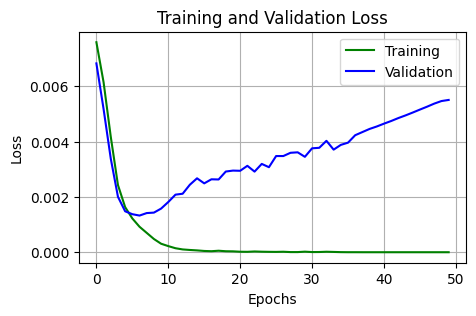

Final Training Loss:   0.0
Final Validation Loss: 0.005507


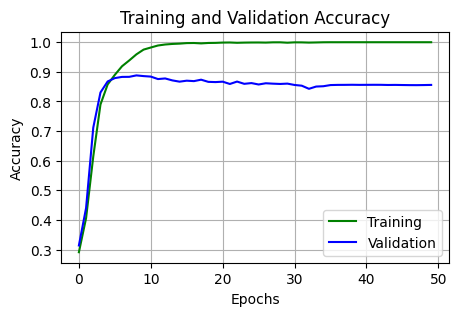

Final Training Accuracy:   1.0
Final Validation Accuracy: 0.855862

Test Accuracy: 0.836467981338501



In [69]:
show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)

In [71]:
torch.save(save_model, "lstm_model_one.pth")

In [82]:
vocab_size = len(all_word_dict)
embedding_dim = 100
hidden_dim = 128
num_classes = 9
num_layers = 2
pretrained = torch.tensor(word_vectors_zero_positiveOne)
dropout = 0.3


glove_model = GloveModel(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, pretrained, dropout)

In [83]:
glove_model = glove_model.float().to(device)

In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 20
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0
     
    for X_train_batch,Y_train_batch in glove_training_dataloader_one:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,torch.max(Y_train_batch, 1)[1])
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim = 1)).float().sum()

        """
        print(f"epoch: {epoch}")
        print(f"Correctedness:{torch.argmax(Y_train_hat,dim=1) == Y_train_batch}")
        print(f"t_num_correct: {t_num_correct}")
        
        print(f"length:{len(train_X_G_one)}")
        print(f"total length: {Y_train_hat.shape}")
        print(f"total batch length: {Y_train_batch.shape}")
        print(f"t_loss:{t_loss}")
        """
        
        
        
        

    training_losses[epoch]   = t_loss/len(train_X_G_one)
    training_accuracy[epoch] = t_num_correct/len(train_X_G_one)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader_one:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,torch.max(Y_val_batch, 1)[1])
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(val_X_G_one)
    val_accuracy[epoch] = v_num_correct/len(val_X_G_one)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]



100%|██████████| 20/20 [14:57<00:00, 44.87s/it]


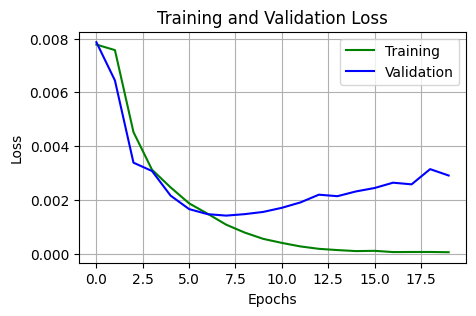

Final Training Loss:   4.8e-05
Final Validation Loss: 0.002902


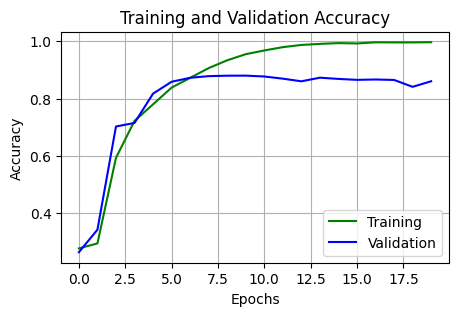

Final Training Accuracy:   0.996981
Final Validation Accuracy: 0.860654

Test Accuracy: 0.8402440547943115



In [85]:
save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()
for X_test_batch,Y_test_batch in glove_testing_dataloader_one:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch,dim=1)).float().sum()

test_accuracy = num_correct_test/len(test_X_G_one)

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)

In [86]:
torch.save(save_model, "lstm_model_two.pth")

In [87]:
vocab_size = len(all_word_dict)
embedding_dim = 100
hidden_dim = 128
num_classes = 9
num_layers = 2
pretrained = torch.tensor(word_vectors_zero_positiveOne)
dropout = 0.5


glove_model = GloveModel(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, pretrained, dropout)
glove_model = glove_model.float().to(device)

100%|██████████| 20/20 [14:57<00:00, 44.87s/it]


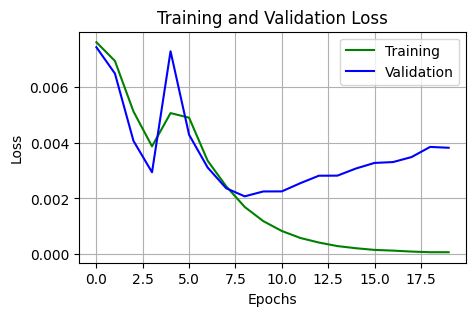

Final Training Loss:   7.1e-05
Final Validation Loss: 0.003821


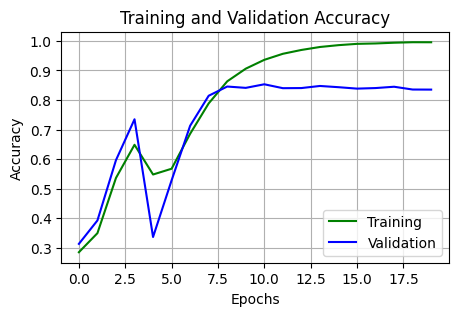

Final Training Accuracy:   0.995363
Final Validation Accuracy: 0.835131

Test Accuracy: 0.7998692989349365



In [88]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 20
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0
     
    for X_train_batch,Y_train_batch in glove_training_dataloader_one:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,torch.max(Y_train_batch, 1)[1])
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim = 1)).float().sum()

        """
        print(f"epoch: {epoch}")
        print(f"Correctedness:{torch.argmax(Y_train_hat,dim=1) == Y_train_batch}")
        print(f"t_num_correct: {t_num_correct}")
        
        print(f"length:{len(train_X_G_one)}")
        print(f"total length: {Y_train_hat.shape}")
        print(f"total batch length: {Y_train_batch.shape}")
        print(f"t_loss:{t_loss}")
        """
        
        
        
        

    training_losses[epoch]   = t_loss/len(train_X_G_one)
    training_accuracy[epoch] = t_num_correct/len(train_X_G_one)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader_one:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,torch.max(Y_val_batch, 1)[1])
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(val_X_G_one)
    val_accuracy[epoch] = v_num_correct/len(val_X_G_one)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]

save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()
for X_test_batch,Y_test_batch in glove_testing_dataloader_one:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch,dim=1)).float().sum()

test_accuracy = num_correct_test/len(test_X_G_one)

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)

In [89]:
torch.save(save_model, "lstm_model_three.pth")

In [90]:
vocab_size = len(all_word_dict)
embedding_dim = 100
hidden_dim = 64
num_classes = 9
num_layers = 2
pretrained = torch.tensor(word_vectors_zero_positiveOne)
dropout = 0.5


glove_model = GloveModel(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, pretrained, dropout)
glove_model = glove_model.float().to(device)

100%|██████████| 20/20 [04:28<00:00, 13.44s/it]


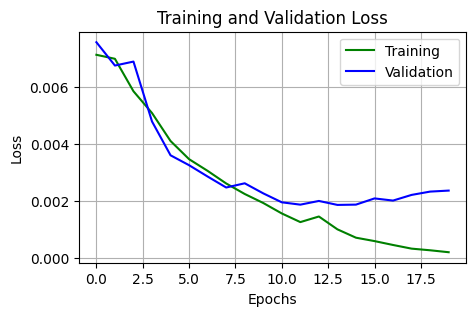

Final Training Loss:   0.000213
Final Validation Loss: 0.002375


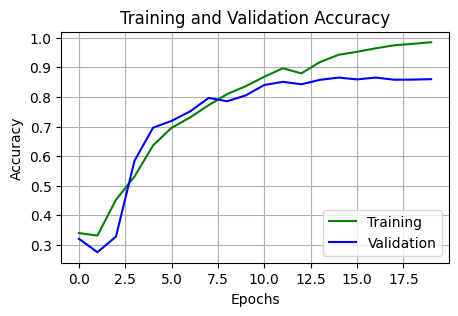

Final Training Accuracy:   0.9847
Final Validation Accuracy: 0.859928

Test Accuracy: 0.8443105220794678



In [91]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 20
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0
     
    for X_train_batch,Y_train_batch in glove_training_dataloader_one:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,torch.max(Y_train_batch, 1)[1])
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim = 1)).float().sum()

        """
        print(f"epoch: {epoch}")
        print(f"Correctedness:{torch.argmax(Y_train_hat,dim=1) == Y_train_batch}")
        print(f"t_num_correct: {t_num_correct}")
        
        print(f"length:{len(train_X_G_one)}")
        print(f"total length: {Y_train_hat.shape}")
        print(f"total batch length: {Y_train_batch.shape}")
        print(f"t_loss:{t_loss}")
        """
        
        
        
        

    training_losses[epoch]   = t_loss/len(train_X_G_one)
    training_accuracy[epoch] = t_num_correct/len(train_X_G_one)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader_one:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,torch.max(Y_val_batch, 1)[1])
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(val_X_G_one)
    val_accuracy[epoch] = v_num_correct/len(val_X_G_one)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]

save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()
for X_test_batch,Y_test_batch in glove_testing_dataloader_one:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch,dim=1)).float().sum()

test_accuracy = num_correct_test/len(test_X_G_one)

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)

In [92]:
torch.save(save_model, "lstm_model_four.pth")

In [38]:
save_model = torch.load('lstm_model_four.pth')
  # testing section
num_correct_test = 0
save_model.eval()
for X_test_batch,Y_test_batch in glove_testing_dataloader_one:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch,dim=1)).float().sum()

test_accuracy = num_correct_test/len(test_X_G_one)


In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


y_true = selected_topics

majority_class = max(set(y_true), key=y_true.count)
y_pred_baseline = [majority_class] * len(y_true)

baseline_accuracy = accuracy_score(y_true, y_pred_baseline)
precision = precision_score(y_true, y_pred_baseline, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred_baseline, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred_baseline, average='macro', zero_division=0)

print(f"Baseline accuracy is {baseline_accuracy}")
print(f"Baseline precision is {precision}")
print(f"Baseline recall is {recall}")
print(f"Baseline F1 score is {f1}")


Baseline accuracy is 0.2304888320892271
Baseline precision is 0.025609870232136345
Baseline recall is 0.1111111111111111
Baseline F1 score is 0.04162552241722302


In [40]:
print(f"The accuracy of the LSTM model is {test_accuracy}")
print(f"Percentage above the baseline is {test_accuracy - baseline_accuracy}")
print(f"Cohen's Kappa is {(test_accuracy-baseline_accuracy)/(1-baseline_accuracy)}")

The accuracy of the LSTM model is 0.8443105220794678
Percentage above the baseline is 0.6138216853141785
Cohen's Kappa is 0.7976774573326111


In [41]:
y_true = torch.argmax(Y_hat_test,dim=1).cpu().numpy()
y_pred = torch.argmax(Y_test_batch,dim=1).cpu().numpy()  

In [42]:
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"The precision of the LSTM model is {precision}")
print(f"The recall of the LSTM model is {recall}")
print(f"F1 score of the LSTM model is {f1}")

The precision of the LSTM model is 0.43394158584032005
The recall of the LSTM model is 0.4639099989112952
F1 score of the LSTM model is 0.4377255599466725
